# 1. Modelling 

(a). Formalize the problem described above. Notice, that not all aspects are formalized precisely. Explain
your choices! Also discuss other possible choices and explain why you decided the way you did.

You may focus on the following aspects:

    - What is the overall objective?

    - How to model the overall situation?

    - What are your assumptions? How can those be justified?

    - If any, why are your approximations/simplifications appropriated?

Depending on the precise objective, the optimization problem which is to be solved may take on slightly different
forms.
(b). Turn your formalization into an optimization problem in standard form.

(c). Implement your approach by writing a Python-script that finds an optimal solution to the problem.
Hint: You may speed up your implementation, if you make use of Linear Programming, Local Optimization or
Markov approaches.

(d). Discuss your results: Do you obtain a good solutions? What are strengths and weaknesses of your
approach and your solution? What problems did you encounter? What caused those problems and how did you
solve them? Analyze the obtained method with respect to the parameters; are your results stable under minimal
changes of the input  data or the initial state? How many resources were needed to obtain that result, i.e. computation time, memory, etc.

## Overall discussion

a) The overall objective is to maximize the water heating system's efficiency. This is done by chosing, for each of the 24 devices, how to warm up the water, either by a local heater or by means of the common boiler. 

Given the objective, our goal was to find a function able to provide us with a number representing the efficiency of using the boiler for the ith device, to be then compared with the 25% efficiency of the local heater. By knowing that, the assignment became extremely simple; if the efficiency of the boiler was less than 25% one would chose the local heater and viceversa. 

The formula we came up with is the following (insert formula)
with:
- c = water heat capacity --> 4,182 kj/kg°C
- m_i = mass of the water needed for the ith device (kg)
- delta_t = temperature increase of water (°C)
- loss_i = energy loss to bring hot water from the boiler to the ith device, along a certain path (kj). Since each path is made by multiple pipes, loss_i is given by (insert formula)
- water_i = water needed by the ith device (l)

Note that loss_i depends on the specific path the water does from the boiler to the device, this must be chosen somehow. We decided to chose the path which minimizes the loss of energy. To do that we built a graph having as nodes the ones provided in pipe_connections, with the arrows representing pipes, to which a weight was assigned as its energy loss. By using the Dijkstra algorithm we could compute the minimum path in terms of energy loss from the boiler to a certain device. 

(where this fomrula come from) --> Useful energy output [energy absprbed by the water] - energy losses / Enrgy input [energy used by the boiler] 

Let's analyze the pros and cons of this formulation. 

Pros:
- Makes sense mathematically and phisically. All the unit of measure simplify, remaining with a kj over kj ratio and so leading to a proportion as wanted. Moreover, higher loss_i and lower is the efficiency, another realistic implication. 
- We can both reason on the single device and on the overall efficiency by aggregating the 24 results into a weighted average efficiency. 

Cons (assumptions):
- how to determine the water demand for the ith device (we set that proportional to the energy usage of the device)
- set system's working hours (parameter)


d) What we like about our results:
- higher the loss of energy of a certain path and lower will be the efficiency of transporting water a long that path. 
- higher the working hours, lower will be the overall efficiency. This is reasonable since the loss of energy associated to each pipe depends by the working hours, so the more a pipe is used, the more heat will lose. 
- Given 2 paths with the same energy loss, the one going to a device with higher demand of water will be less efficient. This happens for the same reason as before. 
- The total amount of water in the boiler does not influence the results, which is great because we get rid of an assumption. 
- all the losses are constant along the time, as asked in the exercise. 

what we don't like about the results:
- the efficiency of each device depends heavier on how much water it needs, which is not easy to determine given the data. 
- the overall efficiency depends on the working hours, which we assumed to be a certain value but it may depend case by case. 
- we assumed working hours to be constant and equal to all devices but thi may be an oversemplification. Some devices may be used more than other sand in different times of the day. 
- 











In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

In [2]:
pipe_connections_df = pd.read_csv('pipe_connections.csv')

pipe_nodes_df = pd.read_csv('pipe_nodes.csv')

project_locations_users_df = pd.read_csv('project_locations_users.csv')

In [4]:
pipe_connections_df.head()

,node_a,node_b,diameter_in_cm,loss_of_energy
0,staffroom_sink,s1,1,3
1,staffroom_shower,s2,2,2
2,washroom_sink,w1,1,3
3,shower_a,a1,2,2
4,bathtub_a,a2,2,2


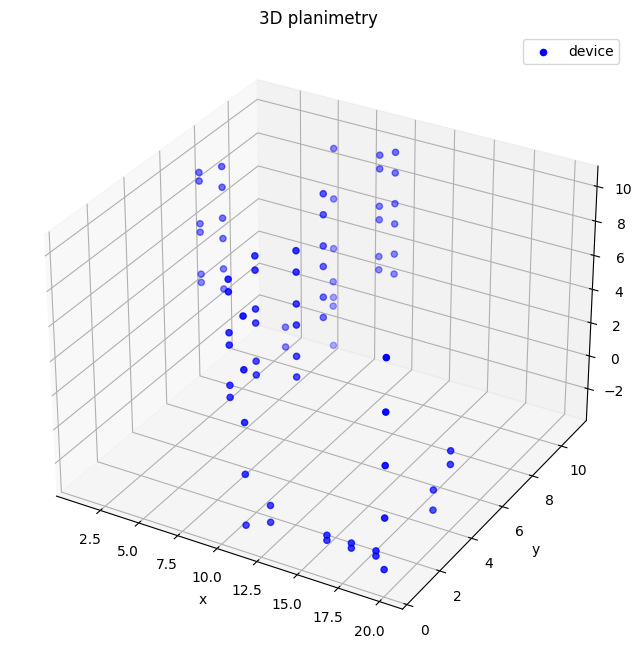

In [5]:
x_coordinates = pipe_nodes_df['x']
y_coordinates = pipe_nodes_df['y']
z_coordinates = pipe_nodes_df['z']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_coordinates, y_coordinates, z_coordinates, marker='o', color='blue', label='device')

ax.set_title('3D planimetry')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
ax.grid(True)

plt.show()


In [6]:
pipe_nodes_df.columns = ['pipe_ID', 'x', 'y', 'z']

pipe_connections1_df = pd.merge(pipe_connections_df, pipe_nodes_df, left_on='node_a', right_on='pipe_ID')
pipe_connections1_df.rename(columns={'x': 'x_a', 'y': 'y_a', 'z': 'z_a'}, inplace=True)

pipe_connections1_df = pd.merge(pipe_connections1_df, pipe_nodes_df, left_on='node_b', right_on='pipe_ID')
pipe_connections1_df.rename(columns={'x': 'x_b', 'y': 'y_b', 'z': 'z_b'}, inplace=True)

pipe_connections1_df['distance_x'] = abs(pipe_connections1_df['x_a'] - pipe_connections1_df['x_b'])
pipe_connections1_df['distance_y'] = abs(pipe_connections1_df['y_a'] - pipe_connections1_df['y_b'])
pipe_connections1_df['distance_z'] = abs(pipe_connections1_df['z_a'] - pipe_connections1_df['z_b'])
pipe_connections1_df['radius_in_cm'] = pipe_connections1_df['diameter_in_cm'] * 0.5


pipe_connections1_df = pipe_connections1_df.drop(columns = ['pipe_ID_x', 'pipe_ID_y','diameter_in_cm'])
pipe_connections1_df['volume'] = (pipe_connections1_df['distance_x'] + pipe_connections1_df['distance_y'] + pipe_connections1_df['distance_z']) * np.power(pipe_connections1_df['radius_in_cm'], 2) * np.pi



In [13]:
pipe_connections1_df.head(10)

,node_a,node_b,loss_of_energy,x_a,y_a,z_a,x_b,y_b,z_b,distance_x,distance_y,distance_z,radius_in_cm,volume
0,staffroom_sink,s1,3,6.0,7.5,1.2,6.0,7.5,0.0,0.0,0.0,1.2,0.5,0.942478
1,d2,s1,2,5.5,11.0,0.0,6.0,7.5,0.0,0.5,3.5,0.0,1.0,12.566371
2,staffroom_shower,s2,2,6.0,10.5,1.5,6.0,10.5,0.0,0.0,0.0,1.5,1.0,4.712389
3,d2,s2,3,5.5,11.0,0.0,6.0,10.5,0.0,0.5,0.5,0.0,0.5,0.785398
4,washroom_sink,w1,3,19.0,4.0,-1.8,19.0,4.0,-3.0,0.0,0.0,1.2,0.5,0.942478
5,d11,w1,2,19.5,0.5,-3.0,19.0,4.0,-3.0,0.5,3.5,0.0,1.0,12.566371
6,shower_a,a1,2,9.0,7.0,4.2,9.0,7.0,3.0,0.0,0.0,1.2,1.0,3.769911
7,a5,a1,3,2.5,7.0,3.0,9.0,7.0,3.0,6.5,0.0,0.0,0.5,5.105088
8,bathtub_a,a2,2,9.0,1.5,3.7,9.0,1.5,3.0,0.0,0.0,0.7,1.0,2.199115
9,d8,a2,3,11.0,0.5,3.0,9.0,1.5,3.0,2.0,1.0,0.0,0.5,2.356194


In [7]:
def min_volume_path(df):
    # Creazione del grafo
    G_volume = nx.Graph()
    G_energy = nx.Graph()

    for index, row in df.iterrows():
        G_volume.add_edge(row['node_a'], row['node_b'], weight=row['volume'])
        G_energy.add_edge(row['node_a'], row['node_b'], weight=row['loss_of_energy'])

    # minimum path from 'boiler' to 'staffroom_shower'
    path_staffroom_shower = nx.dijkstra_path(G_energy, source='boiler', target='staffroom_shower', weight='weight')
    volume_staffroom_shower = sum(G_volume[n][m]['weight'] for n, m in zip(path_staffroom_shower[:-1], path_staffroom_shower[1:]))
    energy_staffroom_shower = sum(G_energy[n][m]['weight'] for n, m in zip(path_staffroom_shower[:-1], path_staffroom_shower[1:]))


    return (path_staffroom_shower, volume_staffroom_shower, energy_staffroom_shower)

(path_staffroom_shower, volume_staffroom_shower, energy_staffroom_shower) = min_volume_path(pipe_connections1_df)

print('Miminum path from boiler to the staffroom shower:', path_staffroom_shower, 'with total volume:', volume_staffroom_shower, 'and total loss of energy:', energy_staffroom_shower)

Miminum path from boiler to the staffroom shower: ['boiler', 'n1', 'd11', 'd12', 's2', 'staffroom_shower'] with total volume: 125.66370614359172 and total loss of energy: 10


In [9]:
list(zip(path_staffroom_shower[:-1], path_staffroom_shower[1:]))

[('boiler', 'n1'),
 ('n1', 'd11'),
 ('d11', 'd12'),
 ('d12', 's2'),
 ('s2', 'staffroom_shower')]

In [33]:
def min_volume_path(df, endpoint):
    # Creazione del grafo
    G_volume = nx.Graph()
    G_energy = nx.Graph()

    for index, row in df.iterrows():
        G_volume.add_edge(row['node_a'], row['node_b'], weight=row['volume'])
        G_energy.add_edge(row['node_a'], row['node_b'], weight=row['loss_of_energy'])

    # minimum path from 'boiler' to 'staffroom_shower'
    path = nx.dijkstra_path(G_volume, source='boiler', target= endpoint, weight='weight')
    volume = sum(G_volume[n][m]['weight'] for n, m in zip(path[:-1], path[1:]))
    energy = sum(G_energy[n][m]['weight'] for n, m in zip(path[:-1], path[1:]))
    
    print('Miminum path from boiler:', path, 'with total volume:', volume, 'and total loss of energy:', energy)

In [15]:
# creating a graph to apply the Dijkstra algorithm, where the vertices are the nodes and the cost of the edges is the volume
def min_volume_energy_paths(df, end_nodes):
    G_volume = nx.Graph()
    G_energy = nx.Graph()

    for _ , row in df.iterrows():
        G_volume.add_edge(row['node_a'], row['node_b'], weight=row['volume'])
        G_energy.add_edge(row['node_a'], row['node_b'], weight=row['loss_of_energy'])

    # cration of the dataframe
    columns = ['path', 'volume', 'energy']
    result_df = pd.DataFrame(columns=columns)

    # computing the minimum path from the boiler to the devices, we are looking for the path with minimum cost of the edges in terms of volume
    for end_node in end_nodes:
        path = nx.dijkstra_path(G_energy, source='boiler', target=end_node, weight='weight') # change volume/energy here  
        volume = sum(G_volume[n][m]['weight'] for n, m in zip(path[:-1], path[1:]))
        energy = sum(G_energy[n][m]['weight'] for n, m in zip(path[:-1], path[1:]))
        
        # adding the results
        result_df = pd.concat([result_df, pd.DataFrame({'path': [path], 'volume': [volume], 'energy': [energy]})], ignore_index=True)

    return result_df

# list of the devices we want to reach
end_nodes = ['staffroom_sink', 'staffroom_shower', 'washroom_sink', 'shower_a',
             'bathtub_a', 'bath_sink_a', 'loo_sink_a', 'kitchen_sink_a',
             'dishwasher_a', 'washing_machine_a', 'shower_b', 'bathtub_b',
             'bath_sink_b', 'loo_sink_b', 'kitchen_sink_b', 'dishwasher_b',
             'washing_machine_b', 'shower_c', 'bathtub_c', 'bath_sink_c',
             'loo_sink_c', 'kitchen_sink_c', 'dishwasher_c',
             'washing_machine_c']


result_df = min_volume_energy_paths(pipe_connections1_df, end_nodes)
result_df.insert(0, 'end nodes', end_nodes)

pd.set_option('display.max_colwidth', None)
result_df


C:\Users\valif\AppData\Local\Temp\ipykernel_5616\1171884522.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'path': [path], 'volume': [volume], 'energy': [energy]})], ignore_index=True)


,end nodes,path,volume,energy
0,staffroom_sink,"[boiler, n1, d6, d7, s1, staffroom_sink]",37.070793,12
1,staffroom_shower,"[boiler, n1, d11, d12, s2, staffroom_shower]",125.663706,10
2,washroom_sink,"[boiler, n1, d11, w1, washroom_sink]",39.426988,10
3,shower_a,"[boiler, n1, d1, d2, d3, a1, shower_a]",83.487825,12
4,bathtub_a,"[boiler, n1, d6, d7, d8, a2, bathtub_a]",52.464597,12
5,bath_sink_a,"[boiler, n1, d6, d7, d8, a2, a3, bath_sink_a]",66.601764,14
6,loo_sink_a,"[boiler, n1, d1, d2, d3, a4, loo_sink_a]",63.852871,13
7,kitchen_sink_a,"[boiler, n1, d1, d2, d3, a1, a5, kitchen_sink_a]",88.592913,15
8,dishwasher_a,"[boiler, n1, d1, d2, d3, a6, dishwasher_a]",64.402649,13
9,washing_machine_a,"[boiler, n1, d11, c7, b7, a7, washing_machine_a]",29.688051,17


In [10]:
for i, item in project_locations_users_df['name'].items():
    
    if project_locations_users_df.loc[i, 'household'] == 'Ahrens':
        project_locations_users_df.at[i, 'name'] = item + '_a'
    
    elif project_locations_users_df.loc[i, 'household'] == 'Becker':
        project_locations_users_df.at[i, 'name'] = item + '_b'

    elif project_locations_users_df.loc[i, 'household'] == 'Chen':
        project_locations_users_df.at[i, 'name'] = item + '_c'

# Now project_locations_users_df has the modified values
project_locations_users_df

,household,name,x,y,z,energy_consumption_in_kJ_per_hour
0,shop,staffroom_sink,6.0,7.5,1.2,80
1,shop,staffroom_shower,6.0,10.5,1.5,8
2,shared,washroom_sink,19.0,4.0,-1.8,20
3,Ahrens,shower_a,9.0,7.0,4.2,600
4,Ahrens,bathtub_a,9.0,1.5,3.7,348
5,Ahrens,bath_sink_a,11.0,3.5,4.2,360
6,Ahrens,loo_sink_a,10.0,10.5,4.2,92
7,Ahrens,kitchen_sink_a,2.5,7.0,4.2,292
8,Ahrens,dishwasher_a,1.0,7.0,3.5,76
9,Ahrens,washing_machine_a,15.5,1.0,-2.7,28


In [16]:
# tanto per avere un grafo dal quale prendersi le varie loss of energy 

Graph = nx.Graph()

for _ , row in pipe_connections1_df.iterrows():
    Graph.add_edge(row['node_a'], row['node_b'], weight=row['loss_of_energy'])
    

In [38]:
eff=[]
for i in range (1,24):

    device = 'staffroom_sink'
    water_tot = 1
    water_i = (water_tot/project_locations_users_df['energy_consumption_in_kJ_per_hour'].sum()) * project_locations_users_df.loc[project_locations_users_df['name']==device, 'energy_consumption_in_kJ_per_hour'].iloc[0]
    heat_capacity = 4.182
    delta_t = 40
    h=i


    loss_i=0

    path= result_df.loc[result_df['end nodes']==device, 'path'].iloc[0]

    for j, node in list(enumerate(path))[:-1]:
        loss_j=Graph[node][path[j+1]]['weight']
        loss_i+= loss_j*water_i*h

    efficiency_i= (water_i * heat_capacity * delta_t - loss_i) / (160 * water_i)

    if efficiency_i < 0:
        efficiency_i = 0

    if efficiency_i > 1:
        efficiency_i=1

    #efficiency_tot += efficiency_i*project_locations_users_df.loc[project_locations_users_df['name']==device, 'energy_consumption_in_kJ_per_hour'].iloc[0]
    #efficiency_tot += efficiency_i
    #print(f'{device} has efficiency = {efficiency_i}')
    eff.append(efficiency_i)



#efficiency_tot/=project_locations_users_df['energy_consumption_in_kJ_per_hour'].sum()
#print(f'avg efficiency is {efficiency_tot}')


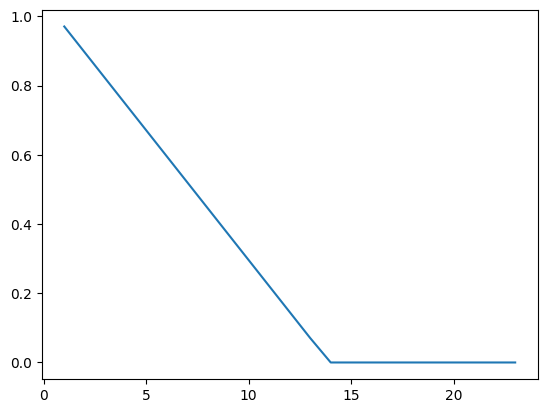

In [39]:
plt.plot(list(range(1,24)), eff)

In [29]:
efficiency_tot=0

for device in project_locations_users_df['name']:

    water_tot = 1
    water_i = (water_tot/project_locations_users_df['energy_consumption_in_kJ_per_hour'].sum()) * project_locations_users_df.loc[project_locations_users_df['name']==device, 'energy_consumption_in_kJ_per_hour'].iloc[0]
    heat_capacity = 4.182
    delta_t = 40
    h=6


    loss_i=0

    path= result_df.loc[result_df['end nodes']==device, 'path'].iloc[0]

    for j, node in list(enumerate(path))[:-1]:
        loss_j=Graph[node][path[j+1]]['weight']
        loss_i+= loss_j*water_i*h

    efficiency_i= (water_i * heat_capacity * delta_t - loss_i) / (160 * water_i)
    
    if efficiency_i < 0:
        efficiency_i = 0
    
    if efficiency_i > 1:
        efficiency_i=1

    efficiency_tot += efficiency_i*project_locations_users_df.loc[project_locations_users_df['name']==device, 'energy_consumption_in_kJ_per_hour'].iloc[0]
    #efficiency_tot += efficiency_i
    print(f'{device} has efficiency = {efficiency_i}')


efficiency_tot/=project_locations_users_df['energy_consumption_in_kJ_per_hour'].sum()
print(f'avg efficiency is {efficiency_tot}')


staffroom_sink has efficiency = 0.5955
staffroom_shower has efficiency = 0.6705000000000002
washroom_sink has efficiency = 0.6705000000000001
shower_a has efficiency = 0.5955000000000001
bathtub_a has efficiency = 0.5955
bath_sink_a has efficiency = 0.5205000000000001
loo_sink_a has efficiency = 0.5580000000000002
kitchen_sink_a has efficiency = 0.48300000000000004
dishwasher_a has efficiency = 0.558
washing_machine_a has efficiency = 0.40800000000000003
shower_b has efficiency = 0.4455000000000001
bathtub_b has efficiency = 0.5205000000000002
bath_sink_b has efficiency = 0.558
loo_sink_b has efficiency = 0.48299999999999993
kitchen_sink_b has efficiency = 0.5205000000000002
dishwasher_b has efficiency = 0.44550000000000023
washing_machine_b has efficiency = 0.5580000000000003
shower_c has efficiency = 0.5205
bathtub_c has efficiency = 0.4455000000000001
bath_sink_c has efficiency = 0.5205000000000001
loo_sink_c has efficiency = 0.48300000000000015
kitchen_sink_c has efficiency = 0.370

In [36]:
eff=[]

for i in range (1,24):

    efficiency_tot=0

    for device in project_locations_users_df['name']:

        water_tot = 1
        water_i = (water_tot/project_locations_users_df['energy_consumption_in_kJ_per_hour'].sum()) * project_locations_users_df.loc[project_locations_users_df['name']==device, 'energy_consumption_in_kJ_per_hour'].iloc[0]
        heat_capacity = 4.182
        delta_t = 40
        h=i


        loss_i=0

        path= result_df.loc[result_df['end nodes']==device, 'path'].iloc[0]

        for j, node in list(enumerate(path))[:-1]:
            loss_j=Graph[node][path[j+1]]['weight']
            loss_i+= loss_j*water_i*h

        efficiency_i= (water_i * heat_capacity * delta_t - loss_i) / (160 * water_i)
        
        if efficiency_i < 0:
            efficiency_i = 0
        
        if efficiency_i > 1:
            efficiency_i=1

        efficiency_tot += efficiency_i*project_locations_users_df.loc[project_locations_users_df['name']==device, 'energy_consumption_in_kJ_per_hour'].iloc[0]
        #efficiency_tot += efficiency_i
        #print(f'{device} has efficiency = {efficiency_i}')


    efficiency_tot/=project_locations_users_df['energy_consumption_in_kJ_per_hour'].sum()

    #print(f'avg efficiency is :{efficiency_tot}')
    eff.append(efficiency_tot)

IndexError: single positional indexer is out-of-bounds

In [37]:
project_locations_users_df['name'][0]

'staffroom_sink'

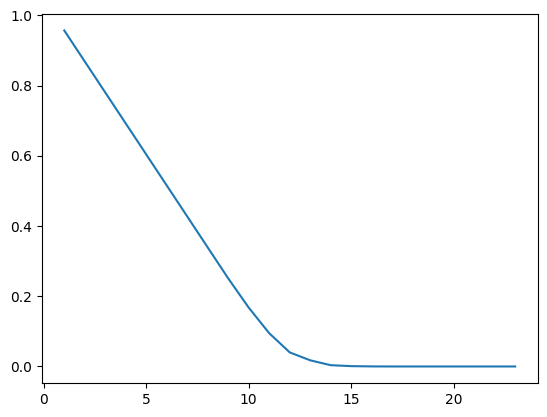

In [27]:
plt.plot(list(range(1,24)), eff)
plt.show()

# 2. Review

Provide a review of the solution presented to you, pay particular attention to the following points:

(a). Please summarize the main idea of the approach in your own words (1-2 sentences or paragraphs).

(b). Describe the strengths and weaknesses of the work, with respect to the following criteria: soundness of the claims (theoretical grounding, empirical evaluation), and clarity of writing.

(c). Do the authors explicitly and clearly state the main assumptions and limitations of their approach? Are there hidden assumptions?

(d). Is the approach technically sound? The claims and conclusions are supported by flawless arguments. Proofs are
correct, formulas are correct. Are the assumptions empirically checked and validated?

(e). Are the experiments well designed, sufficient, clearly described?

(f). Is the work well-organized and clearly written, should there be additional explanations or illustrations?